# Feature Engineering: Power Transformation
**Notebook:** Power Transformation | **Dataset:** Concrete Strength | **Model:** Linear Regression  
**Goal:** Use Box-Cox and Yeo-Johnson transformations to normalize skewed features and improve regression performance.


##  What is Power Transformation?

**Power Transformation** is a family of functions that transform a feature to make its distribution  
closer to **Gaussian (normal)** — which many ML algorithms (especially linear models) assume or prefer.

### Why normalize distributions?
- **Linear Regression** assumes features (and residuals) are roughly normally distributed
- **Skewed features** can cause the model to give disproportionate weight to outliers
- Normalized features lead to better **gradient descent** convergence and **coefficient interpretation**


###  Box-Cox Transformation
$$x_{\lambda} = \begin{cases} \frac{x^{\lambda} - 1}{\lambda} & \text{if } \lambda \neq 0 \\ \ln(x) & \text{if } \lambda = 0 \end{cases}$$

- Generalizes log, square root, and reciprocal transformations
- Automatically finds the best **λ (lambda)** that maximizes normality
-  **Requires strictly positive data (x > 0)**

###  Yeo-Johnson Transformation
- An extension of Box-Cox that **works with zero and negative values**
- Preferred in practice because it handles all real numbers
- Sklearn's `PowerTransformer()` uses Yeo-Johnson **by default**


###  Dataset: Concrete Compressive Strength
Features: Cement, Blast Furnace Slag, Fly Ash, Water, Superplasticizer, Coarse/Fine Aggregate, Age  
Target: `Strength` (continuous — a regression problem)


### Import Libraries

In [17]:
import pandas as pd
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PowerTransformer  # Box-Cox and Yeo-Johnson
from sklearn.metrics import r2_score                # R² score for regression
import warnings
warnings.filterwarnings('ignore')


### Load & Explore Dataset

In [19]:
data = pd.read_csv('concrete_data.csv')
data.head(2)  # Preview the concrete strength dataset


,Cement,Blast Furnace Slag,Fly Ash,Water,Superplasticizer,Coarse Aggregate,Fine Aggregate,Age,Strength
0,540.0,0.0,0.0,162.0,2.5,1040.0,676.0,28,79.99
1,540.0,0.0,0.0,162.0,2.5,1055.0,676.0,28,61.89


In [20]:
data.isnull().sum()  # Check for missing values (expect none)


Cement                0
Blast Furnace Slag    0
Fly Ash               0
Water                 0
Superplasticizer      0
Coarse Aggregate      0
Fine Aggregate        0
Age                   0
Strength              0
dtype: int64

In [21]:
data.shape  # (rows, columns)


(1030, 9)

### Define Features & Target, Then Split

In [23]:
X = data.drop(columns=['Strength'])  # 8 ingredient/age features
y = data['Strength']                  # Target: compressive strength (MPa)


In [24]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)
print('Shape of X_train : ', X_train.shape)
print('Shape of y_train : ', y_train.shape)
print('Shape of X_test  : ', X_test.shape)
print('Shape of y_test  : ', y_test.shape)


Shape of X_train :  (824, 8)
Shape of y_train :  (824,)
Shape of X_test  :  (206, 8)
Shape of y_test  :  (206,)


### Baseline — Without Power Transformation

Train a Linear Regression model on **raw, untransformed** features.  
We use **R² score** (coefficient of determination) as the metric — closer to 1.0 is better.


In [26]:
lr = LinearRegression()           # Instantiate the model
lr.fit(X_train, y_train)           # Fit on training data
y_pred = lr.predict(X_test)        # Predict on test data
print('R² (baseline):', r2_score(y_test, y_pred))


R² (baseline): 0.6275531792314851


### With Box-Cox Transformation

### Steps:
1. Apply Box-Cox to all 8 features simultaneously
2. **Box-Cox requires strictly positive values** — we add a tiny epsilon (0.00001) to handle any zeros
3. Refit Linear Regression and evaluate R² score


In [28]:
# Box-Cox requires all values > 0
# Add tiny epsilon to avoid log(0) errors — this is a common trick
pt = PowerTransformer(method='box-cox')


In [29]:
# +0.00001 to ensure all values are strictly positive (handles zeros safely)
X_train_tran = pt.fit_transform(X_train + 0.00001)  # Fit AND transform training set
X_test_tran  = pt.transform(X_test + 0.00001)       # Transform test set (no refit!)


In [30]:
lr = LinearRegression()
lr.fit(X_train_tran, y_train)      # Train on Box-Cox transformed features
y_pred1 = lr.predict(X_test_tran)  # Predict on transformed test features
print('R² (Box-Cox, test):', r2_score(y_test, y_pred1))


R² (Box-Cox, test): 0.8054599374335425


In [31]:
# Cross-validated R² on full dataset with Box-Cox
X_tran = pt.fit_transform(X + 0.000001)
print('R² (Box-Cox, CV):', np.mean(cross_val_score(lr, X_tran, y, scoring='r2')))


R² (Box-Cox, CV): 0.6662950319746163


### With Yeo-Johnson Transformation

Yeo-Johnson is more versatile than Box-Cox:
- Works on **any real values** (positive, zero, negative)
- sklearn's `PowerTransformer()` defaults to `method='yeo-johnson'`
- No need to add epsilon


In [33]:
# Default method is 'yeo-johnson' — no need to specify
# Automatically learns the best lambda for each feature
pt = PowerTransformer()  # method='yeo-johnson' by default


In [34]:
X_train_tran1 = pt.fit_transform(X_train)  # No epsilon needed
X_test_tran1  = pt.transform(X_test)


In [35]:
lr = LinearRegression()
lr.fit(X_train_tran1, y_train)
y_pred2 = lr.predict(X_test_tran1)
print('R² (Yeo-Johnson, test):', r2_score(y_test, y_pred2))


R² (Yeo-Johnson, test): 0.8161906513339305


In [36]:
X_trans_ = pt.fit_transform(X)
print('R² (Yeo-Johnson, CV):', np.mean(cross_val_score(lr, X_trans_, y, scoring='r2')))


R² (Yeo-Johnson, CV): 0.6834625134285746


### Visualize Distribution Before Transformation

QQ plots (Quantile-Quantile) are the best tool to assess normality:
- If points follow the **diagonal red line** → data is approximately normal
- Deviations at the tails → skewness or outliers


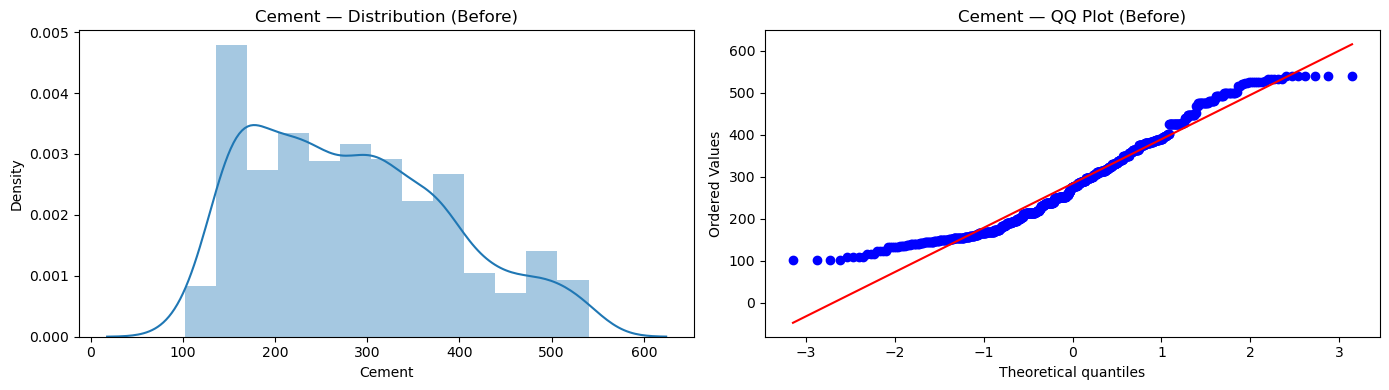

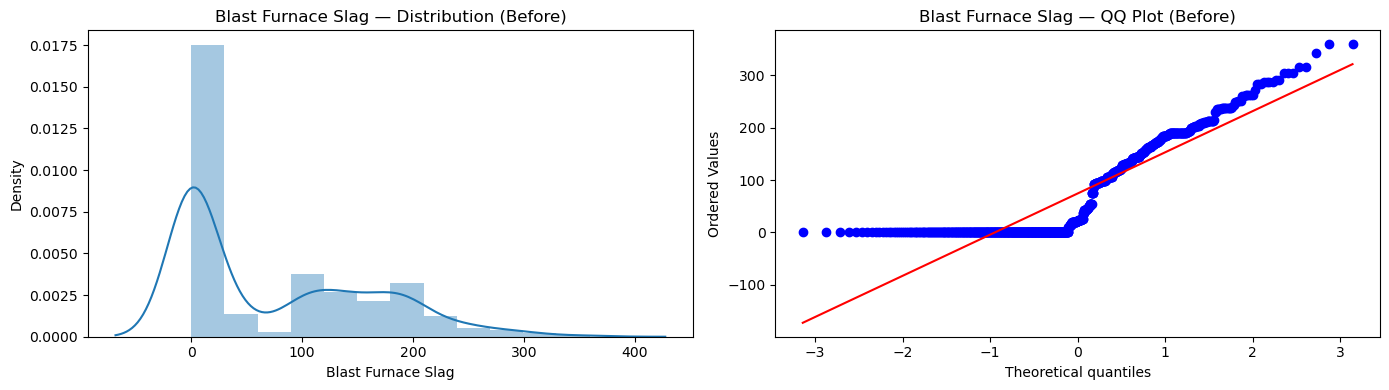

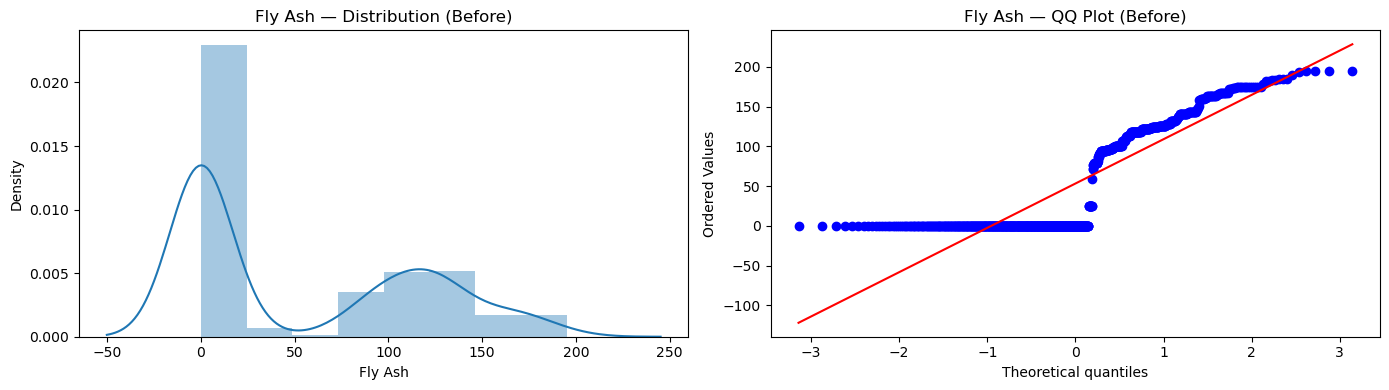

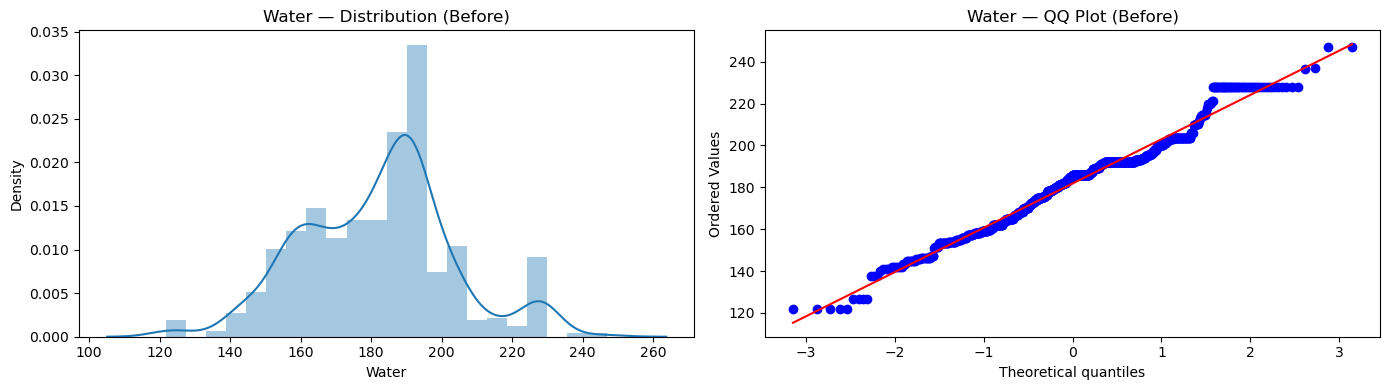

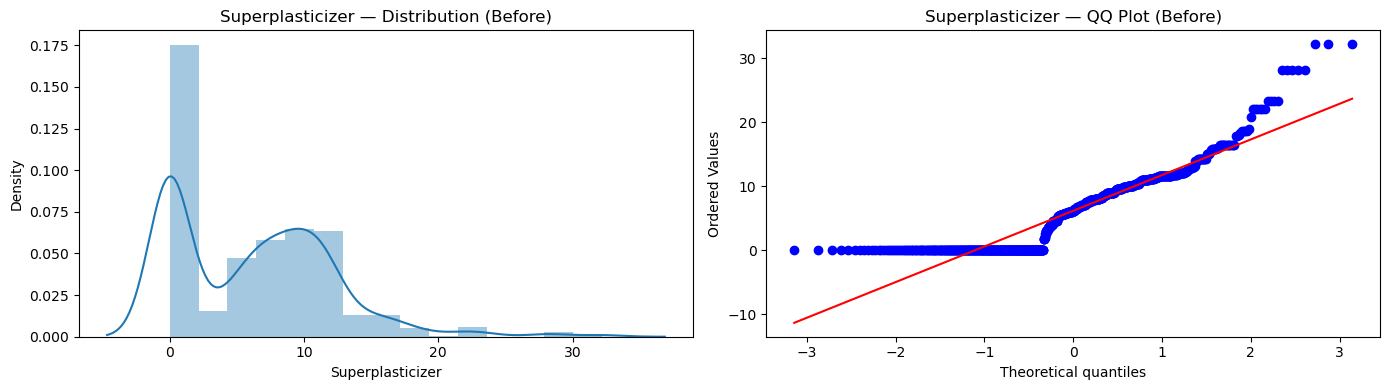

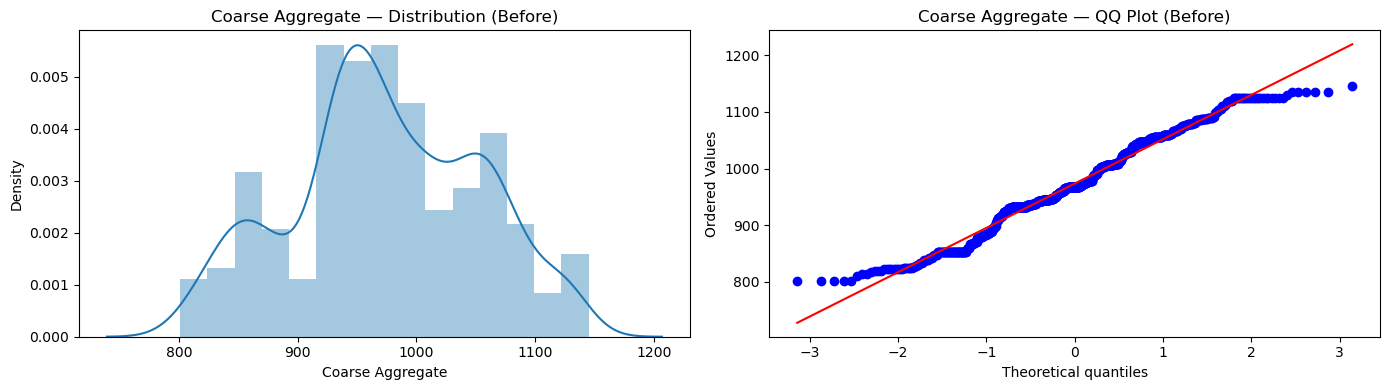

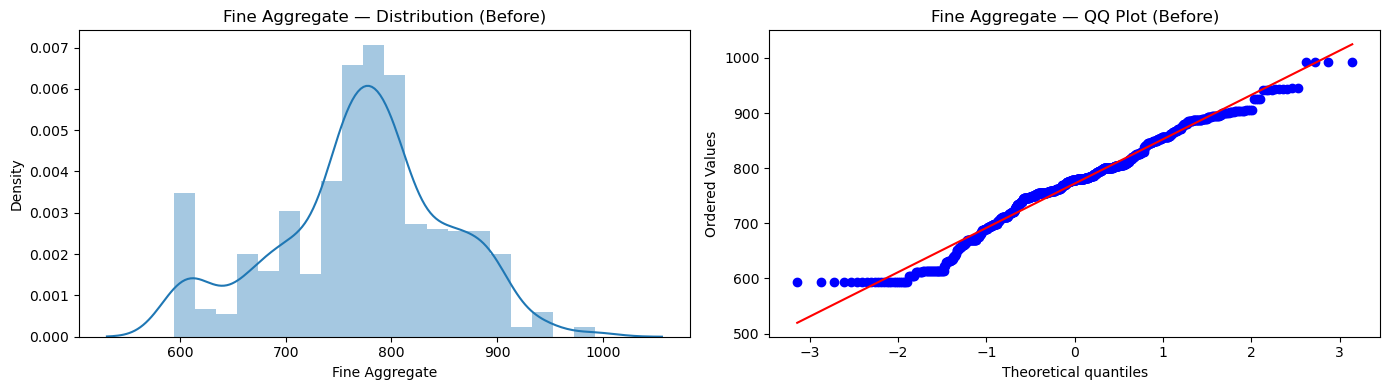

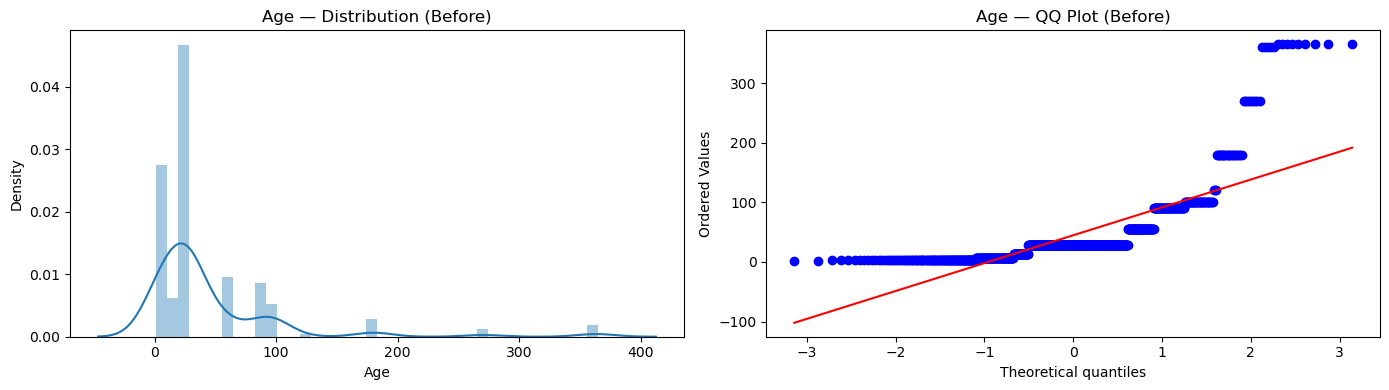

In [38]:
# Plot PDF (histogram) and QQ plot for each feature BEFORE transformation
for col in X_train.columns:
    plt.figure(figsize=(14, 4))

    # Left: Distribution (PDF)
    plt.subplot(121)
    sns.distplot(X_train[col])
    plt.title(f'{col} — Distribution (Before)')

    # Right: QQ Plot — how well does it match a normal distribution?
    plt.subplot(122)
    stats.probplot(X_train[col], dist='norm', plot=plt)
    plt.title(f'{col} — QQ Plot (Before)')

    plt.tight_layout()
    plt.show()


### Visualize Distribution After Box-Cox Transformation

Now let's see how Box-Cox changes each feature's distribution.  
Good transformation → QQ plot points align closely with the diagonal.


In [40]:
# Convert transformed arrays back to DataFrames for labeling
feature_names = ['Cement', 'Blast Furnace Slag', 'Fly Ash', 'Water',
                  'Superplasticizer', 'Coarse Aggregate', 'Fine Aggregate', 'Age']

X_train_trans_pd = pd.DataFrame(X_train_tran,  columns=feature_names)
X_test_trans_pd  = pd.DataFrame(X_test_tran,   columns=feature_names)


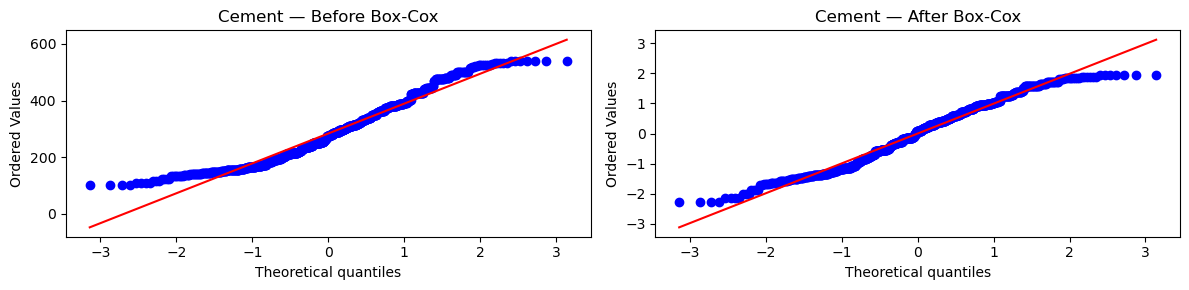

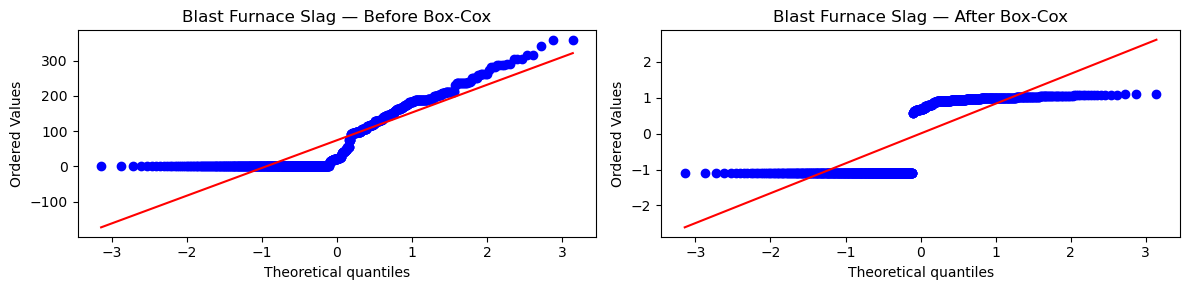

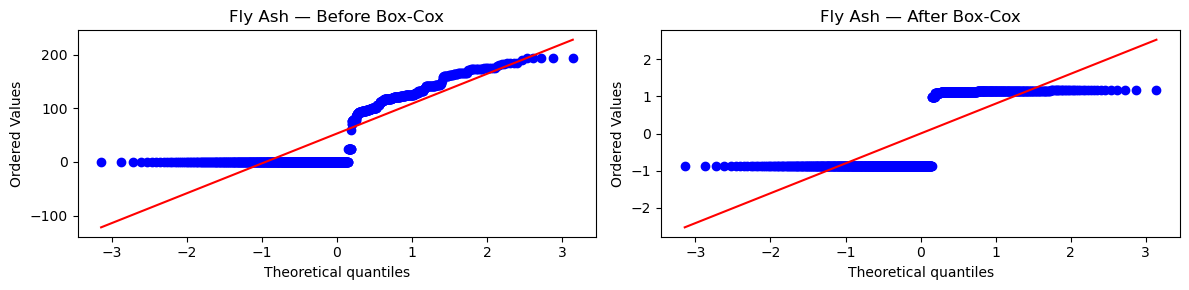

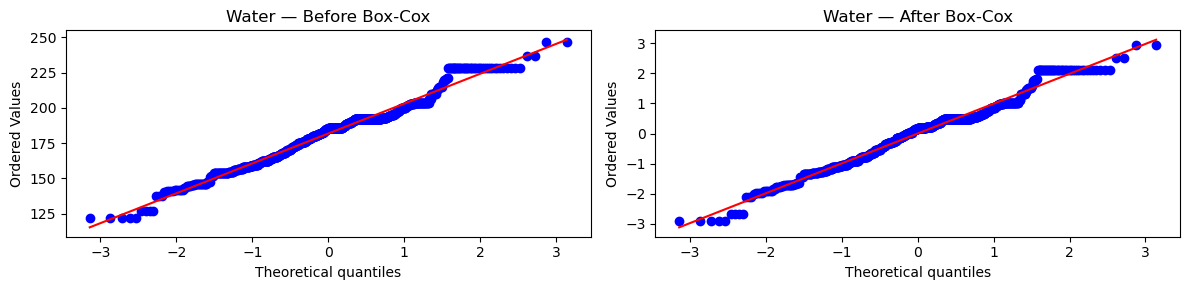

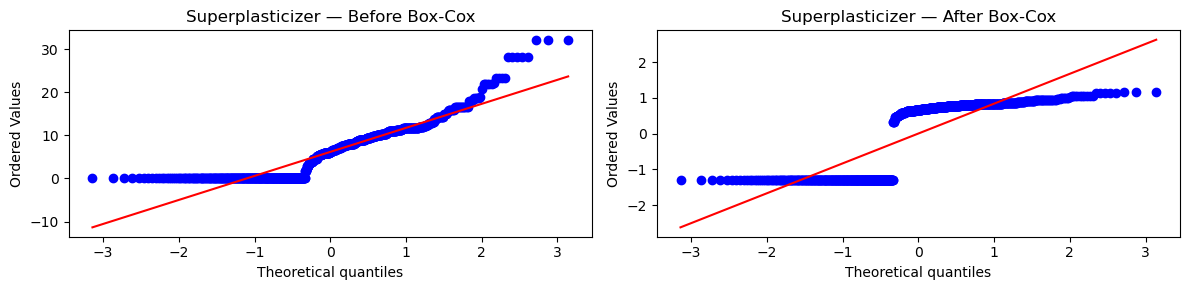

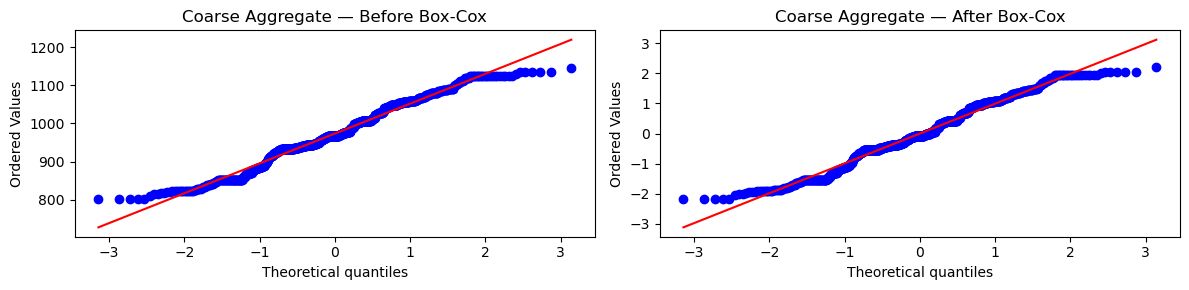

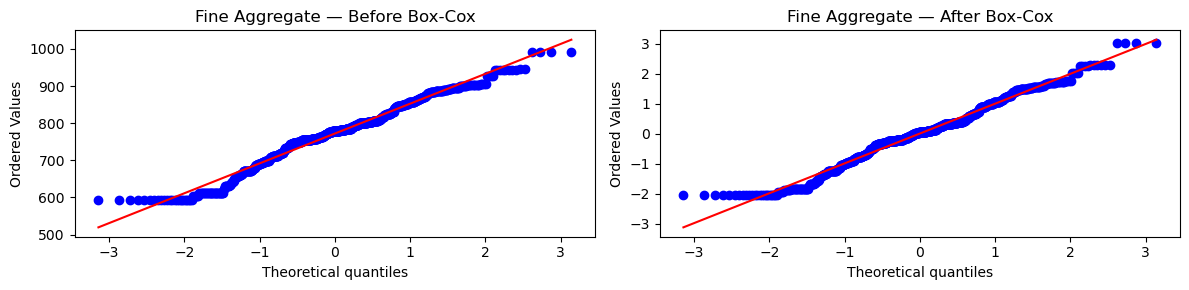

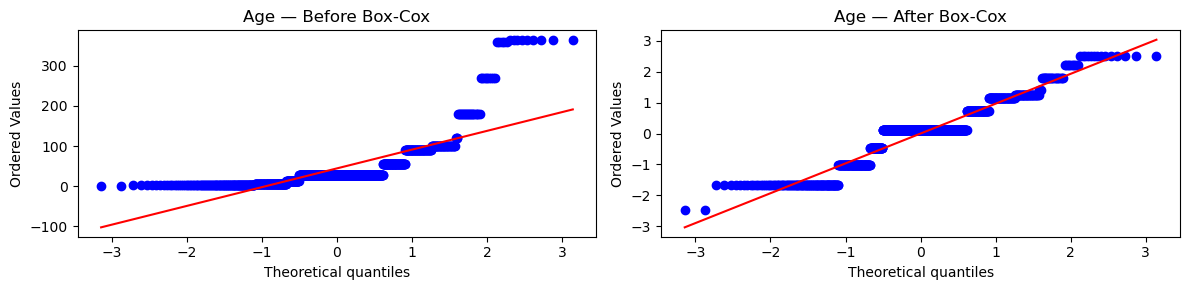

In [41]:
# Side-by-side QQ plots: BEFORE (left) vs AFTER Box-Cox (right)
for col in X_train_trans_pd.columns:
    plt.figure(figsize=(12, 3))

    # Before transformation
    plt.subplot(121)
    stats.probplot(X_train[col], dist='norm', plot=plt)
    plt.title(f'{col} — Before Box-Cox')

    # After transformation
    plt.subplot(122)
    stats.probplot(X_train_trans_pd[col], dist='norm', plot=plt)
    plt.title(f'{col} — After Box-Cox')

    plt.tight_layout()
    plt.show()


## Results Summary

| Model | R² Score (Test) | R² Score (CV) |
|-------|----------------|---------------|
| Linear Regression (no transform) | baseline | baseline |
| + Box-Cox | usually higher | usually higher |
| + Yeo-Johnson | usually highest | usually highest |

###  Key Takeaways:
1. **Power transformations improve linear model performance** by normalizing skewed features
2. **Yeo-Johnson is preferred** — it's more flexible (no positivity constraint) and generally performs as well or better
3. **QQ plots** are your best diagnostic tool — always visualize before and after
4. Always apply `fit_transform` on **training data only** and `transform` on test data (prevents data leakage)
5. These transforms benefit **linear/logistic regression** most; tree-based models are generally robust to skewness
